In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import os
import cv2

## Dataset preparation

In [13]:
DATASET_DIR = '../dataset'
TRAIN_DIR = '../datasplit/train'
VAL_DIR = '../datasplit/validation'
TEST_DIR = '../datasplit/test'
DATASET_SPLIT_DIR = '../datasplit'  # path to your dataset

In [14]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path to your dataset
source_dir = DATASET_DIR
data_split_dir = DATASET_SPLIT_DIR
train_dir = TRAIN_DIR
val_dir = VAL_DIR
test_dir = TEST_DIR

# Create data split directory
os.makedirs(data_split_dir, exist_ok=True)

# For each country folder
for country in os.listdir(source_dir):
    country_path = os.path.join(source_dir, country)
    if os.path.isdir(country_path):
        # Create country directories in train, val, test
        os.makedirs(os.path.join(train_dir, country), exist_ok=True)
        os.makedirs(os.path.join(val_dir, country), exist_ok=True)
        os.makedirs(os.path.join(test_dir, country), exist_ok=True)
        
        # Get all images in this country folder
        images = [f for f in os.listdir(country_path) if f.endswith(('.jpg', '.png'))]
        
        # Split into train, val, test (70/15/15)
        train_imgs, test_val_imgs = train_test_split(images, test_size=0.3, random_state=42)
        val_imgs, test_imgs = train_test_split(test_val_imgs, test_size=0.5, random_state=42)
        
        # Copy images to their respective directories
        for img in train_imgs:
            shutil.copy(os.path.join(country_path, img), os.path.join(train_dir, country, img))
        for img in val_imgs:
            shutil.copy(os.path.join(country_path, img), os.path.join(val_dir, country, img))
        for img in test_imgs:
            shutil.copy(os.path.join(country_path, img), os.path.join(test_dir, country, img))


Train set:
France: 2501 images
Japan: 2688 images
South Africa: 828 images


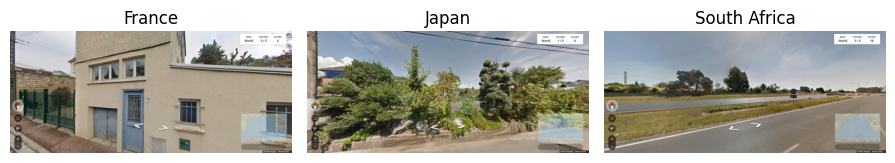


Validation set:
France: 536 images
Japan: 576 images
South Africa: 177 images


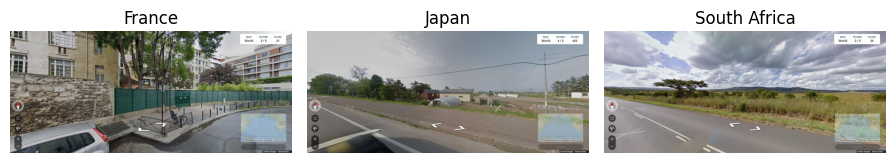


Test set:
France: 536 images
Japan: 576 images
South Africa: 178 images


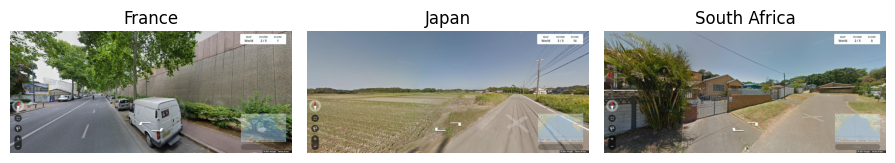

In [15]:
# Check class distribution
for split in ['train', 'validation', 'test']:
    print(f"\n{split.capitalize()} set:")
    for country in os.listdir(f'{DATASET_SPLIT_DIR}/{split}/'):
        count = len(os.listdir(f'{DATASET_SPLIT_DIR}/{split}/{country}/'))
        print(f"{country}: {count} images")
        
    # Display sample images
    plt.figure(figsize=(15, 10))
    for i, country in enumerate(list(os.listdir(f'{DATASET_SPLIT_DIR}/{split}/'))):
        country_path = os.path.join(f'{DATASET_SPLIT_DIR}/{split}/', country)
        sample_img = os.path.join(country_path, os.listdir(country_path)[0])
        img = cv2.imread(sample_img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(country)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## Data reprocessing

In [16]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using datagen
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Flow validation images in batches of 32 using datagen
val_generator = datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Flow test images in batches of 32 using datagen
test_generator = datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 6017 images belonging to 3 classes.
Found 1289 images belonging to 3 classes.
Found 1290 images belonging to 3 classes.


## Model Development

In [17]:
# --- Build the Transfer Learning Model ---
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  # Freeze convolutional base

x = base_model.output
# Flatten the output layers to 2 dimension
x = GlobalAveragePooling2D()(x)
# Reduce overfitting by randomly removing 30% of neurons during training
x = Dropout(0.3)(x)
# Add a fully connected layer with 128 hidden units and ReLU activation
x = Dense(128, activation='relu')(x)
# Reduce overfitting by randomly removing 30% of neurons during training
x = Dropout(0.3)(x)
# Model Multi-layer classification
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Concatenate the original model and the classifier you added into a complete model
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 128, 128,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 128, 128,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 4,213,926 (16.07 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

                                                                                                  
 block4b_activation (Activation  (None, 8, 8, 480)   0           ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     
                                                                                                  
 block4b_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block4b_se_reshape[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_se_excite (Multiply)   (None, 8, 8, 480)    0           ['block5a_activation[0][0]',     
                                                                  'block5a_se_expand[0][0]']      
          

                                                                                                  
 block5c_project_conv (Conv2D)  (None, 8, 8, 112)    75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 8, 8, 112)   448         ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 8, 8, 112)    0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_add (Add)              (None, 8, 8, 112)    0           ['block5c_drop[0][0]',           
                                                                  'block5b_add[0][0]']            
          

                                                                                                  
 block6b_add (Add)              (None, 4, 4, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 4, 4, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 4, 4, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6c_expand_activation (Act  (None, 4, 4, 1152)  0           ['block6c_expand_bn[0][0]']      
 ivation) 

                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 4, 4, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 4, 4, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 4, 4, 1152)  10368       ['block7a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block7a_b

In [19]:
## Train the Model

In [20]:
EPOCHS = 10  # we could change the epouch, up to us

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)


/opt/homebrew/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 67s 328ms/step - accuracy: 0.4399 - loss: 1.0359 - val_accuracy: 0.4469 - val_loss: 0.9984
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 57s 304ms/step - accuracy: 0.4337 - loss: 1.0106 - val_accuracy: 0.4469 - val_loss: 0.9983
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 55s 291ms/step - accuracy: 0.4262 - loss: 1.0014 - val_accuracy: 0.4469 - val_loss: 0.9982
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 713s 4s/step - accuracy: 0.4374 - loss: 1.0037 - val_accuracy: 0.4469 - val_loss: 0.9974
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 65s 344ms/step - accuracy: 0.4136 - loss: 1.0055 - val_accuracy: 0.4469 - val_loss: 0.9985
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 57s 302ms/step - accuracy: 0.4400 - loss: 1.0110 - val_accuracy: 0.4158 - val_loss: 0.9973
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 56s 298ms/step - accuracy: 0.4371 - loss: 1.0038 - val_accuracy: 0.4469 - val_loss: 0.9995
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 56s 297ms/step - accuracy: 0.4515 - loss: 1.0

In [21]:
## Visualize Training History

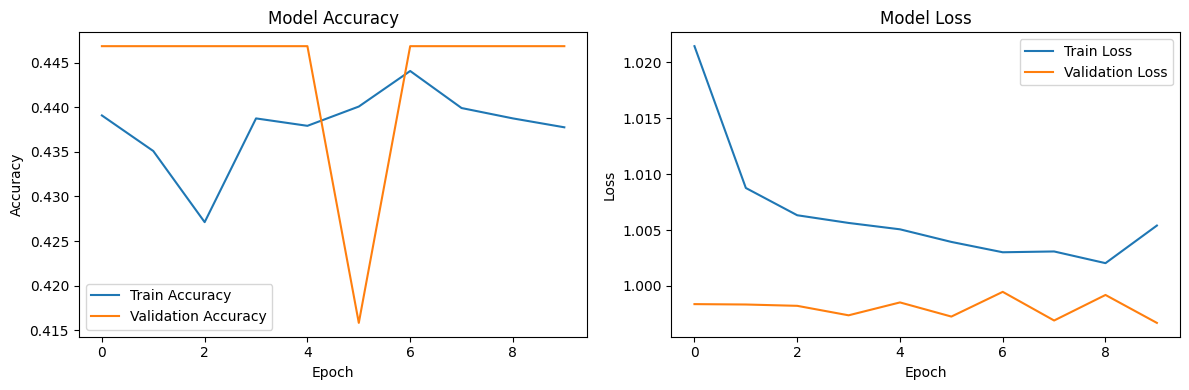

In [22]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
## Evaluate and Test

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.2244 - loss: 0.8793
Test Accuracy: 0.4465, Test Loss: 0.9975
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step


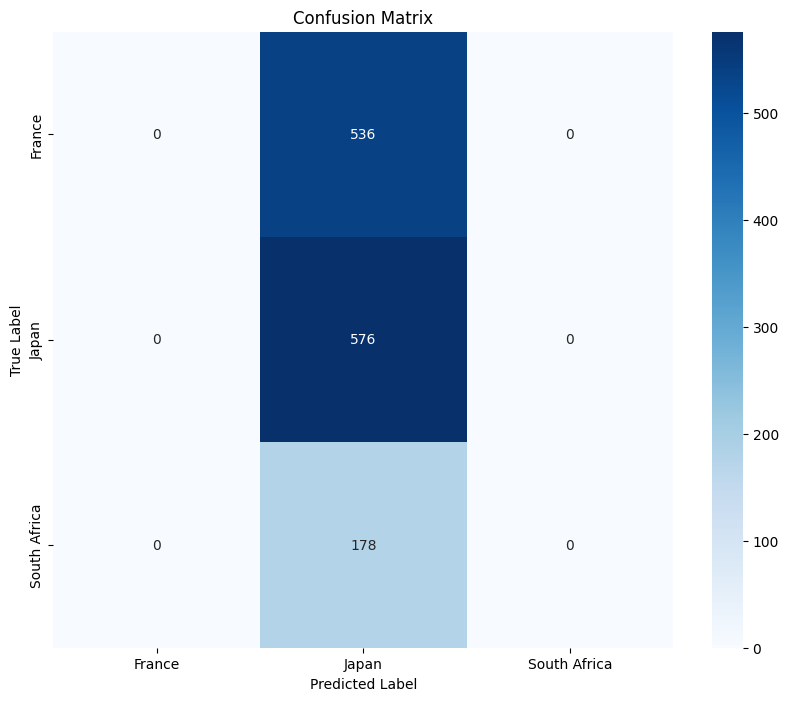

              precision    recall  f1-score   support

      France       0.00      0.00      0.00       536
       Japan       0.45      1.00      0.62       576
South Africa       0.00      0.00      0.00       178

    accuracy                           0.45      1290
   macro avg       0.15      0.33      0.21      1290
weighted avg       0.20      0.45      0.28      1290



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
# Evaluate model on test set
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Predict on test images
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)


In [28]:
## Predict a Random Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


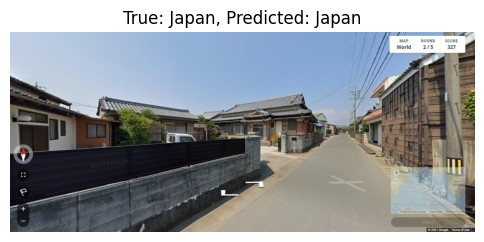

In [29]:
import random

# Randomly select a country folder from the test set
random_country = random.choice(os.listdir(TEST_DIR))
country_dir = os.path.join(TEST_DIR, random_country)

# Randomly select an image from that folder
random_img_path = os.path.join(country_dir, random.choice(os.listdir(country_dir)))

# Read and preprocess the image
img = cv2.imread(random_img_path)
img_resized = cv2.resize(img, IMG_SIZE)
img_normalized = img_resized / 255.0
img_expanded = np.expand_dims(img_normalized, axis=0)  # Add batch dimension

# Make prediction
prediction = model.predict(img_expanded)
predicted_class = np.argmax(prediction, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Display the image and prediction result
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"True: {random_country}, Predicted: {class_labels[predicted_class[0]]}")
plt.axis('off')
plt.show()
